# Using Reinforcement Learning for Generator Optimization


### 1. Import the Necessary Packages

In [1]:
import sys
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

Set plotting options

In [2]:
%matplotlib inline
plt.style.use('ggplot')
np.set_printoptions(precision=3, linewidth=120)

### 2. Specify the Environment, and Explore the State and Action Spaces

We'll use [OpenAI Gym](https://gym.openai.com/) environments to test and develop our algorithms. These simulate a variety of classic as well as contemporary reinforcement learning tasks.  Let's use an environment that has a continuous state space, but a discrete action space.

Create the PowerPlant environment

In [3]:
env = gym.make('gym_powerplant:powerplant_complex-v0')

/home/tdird/anaconda3/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Run the next code cell to watch a random agent.

In [26]:
state = env.reset()
score = 0

for t in range(3000):
    action = env.action_space.sample()
    env.render()
    state, reward, done, _ = env.step(action)
    #print(state)
    score += reward
    if done:
        break 

print('Final score:', score)

env.close()

Final score: -1677.0


In [28]:
type(state)

numpy.ndarray

In [27]:
state

array([432.042, 483.   , 485.   , 447.   , 367.   ,   1.   ,   0.   ])

Explore state (observation) space

In [5]:
print("State space:", env.observation_space)
print("- low:", env.observation_space.low)
print("- high:", env.observation_space.high)

State space: Box(0.0, 1449.0, (7,), float32)
- low: [0. 0. 0. 0. 0. 0. 0.]
- high: [ 835. 1449.  370.  370.  370.    3.    3.]


Generate some samples from the state space 

In [6]:
print("State space samples:")
sss = np.array([env.observation_space.sample() for i in range(10)])
print(sss)

State space samples:
[[3.271e+02 1.073e+03 2.994e+02 6.688e+01 3.257e+02 2.155e+00 1.123e+00]
 [4.185e+02 3.513e+02 3.045e+02 1.498e+02 2.209e+02 2.743e+00 1.257e-01]
 [9.468e+01 2.517e+01 3.238e+02 9.992e+01 3.411e+02 2.939e+00 9.697e-01]
 [8.194e+02 4.080e+02 1.012e+02 2.869e+02 3.116e+02 2.653e+00 7.991e-02]
 [7.395e+02 1.366e+02 2.035e+02 1.228e+02 3.698e+02 6.200e-01 7.539e-01]
 [2.810e+02 3.290e+02 6.381e+01 2.894e+02 3.424e+02 7.880e-01 2.414e+00]
 [5.424e+02 5.029e+02 3.426e+02 3.594e+02 3.171e+02 2.171e+00 1.551e+00]
 [6.846e+02 1.204e+02 3.554e+02 1.108e+01 1.464e+02 8.119e-01 1.267e+00]
 [6.252e+02 1.139e+02 2.876e+02 3.614e+02 3.194e+02 2.982e+00 2.447e+00]
 [5.847e+01 8.054e+02 2.018e+02 1.313e+02 2.097e+02 5.094e-01 2.442e+00]]


Explore the action space

In [7]:
print("Action space:", env.action_space)

Action space: Discrete(10)


Generate some samples from the action space

In [8]:
print("Action space samples:")
ass = np.array([env.action_space.sample() for i in range(10)])
print(ass)

Action space samples:
[6 1 1 2 2 0 1 6 6 4]


### 3. Discretize the State Space with a Uniform Grid

In [9]:
def create_uniform_grid(low, high, bins=(10, 10, 10, 10, 10, 3, 3)):
    """Define a uniformly-spaced grid that can be used to discretize a space.
    
    Parameters
    ----------
    low : array_like
        Lower bounds for each dimension of the continuous space.
    high : array_like
        Upper bounds for each dimension of the continuous space.
    bins : tuple
        Number of bins along each corresponding dimension.
    
    Returns
    -------
    grid : list of array_like
        A list of arrays containing split points for each dimension.
    """

    dim = len(bins)
    grid = [np.linspace(low[d], high[d], bins[d] + 1)[1:-1] for d in range(dim)]
        
    print("Uniform grid: [<low>, <high>] / <bins> => <splits>")
    
    for l, h, b, splits in zip(low, high, bins, grid):
        print("    [{}, {}] / {} => {}".format(l, h, b, splits))
    
    return grid

low  = [-1.0, -5.0, -5.0, -5.0, -5.0, 0, 0]
high = [ 1.0,  5.0,  5.0,  5.0,  5.0, 3, 3]
create_uniform_grid(low, high)  # test

Uniform grid: [<low>, <high>] / <bins> => <splits>
    [-1.0, 1.0] / 10 => [-0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8]
    [-5.0, 5.0] / 10 => [-4. -3. -2. -1.  0.  1.  2.  3.  4.]
    [-5.0, 5.0] / 10 => [-4. -3. -2. -1.  0.  1.  2.  3.  4.]
    [-5.0, 5.0] / 10 => [-4. -3. -2. -1.  0.  1.  2.  3.  4.]
    [-5.0, 5.0] / 10 => [-4. -3. -2. -1.  0.  1.  2.  3.  4.]
    [0, 3] / 3 => [1. 2.]
    [0, 3] / 3 => [1. 2.]


[array([-0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8]),
 array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.]),
 array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.]),
 array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.]),
 array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.]),
 array([1., 2.]),
 array([1., 2.])]

In [10]:
def discretize(sample, grid):
    """Discretize a sample as per given grid.
    
    Parameters
    ----------
    sample : array_like
        A single sample from the (original) continuous space.
    grid : list of array_like
        A list of arrays containing split points for each dimension.
    
    Returns
    -------
    discretized_sample : array_like
        A sequence of integers with the same number of dimensions as sample.
    """
    
    # apply along each dimension
    discretized_sample = list(int(np.digitize(s, g)) for s, g in zip(sample, grid))
    
    return discretized_sample  

Test with a simple grid and some samples

In [11]:
low  = [-1.0, -5.0, -10, -10, -10, 0, 0]
high = [ 1.0,  5.0,  10,  10,  10, 3, 3]
grid = create_uniform_grid(low, high)

samples = np.array(
    [[-1.00, 5.0,  10.0,  9.4,  9.0, 0.0, 1.0],
     [-0.81, 4.1,   4.0,  5.6,  7.5, 1.0, 2.0],
     [-0.80, 4.0, -10.0, -2.0,  7.8, 1.0, 3.0],
     [-0.50, 0.0,  -9.0, -4.0,  4.4, 1.0, 1.0],
     [ 0.20, 1.9,   9.0,  2.3,  7.0, 1.0, 1.0],
     [ 0.80, 4.0,  -2.0,  6.6,  6.9, 1.0, 0.0],
     [ 0.81, 4.1,   2.0, -1.2,  8.8, 1.0, 2.0],
     [ 1.00, 5.0,  10.0, -9.0, -3.0, 0.0, 3.0]])

discretized_samples = np.array([discretize(sample, grid) for sample in samples])

print("\nSamples:", repr(samples), sep="\n")
print("\nDiscretized samples:", repr(discretized_samples), sep="\n")

Uniform grid: [<low>, <high>] / <bins> => <splits>
    [-1.0, 1.0] / 10 => [-0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8]
    [-5.0, 5.0] / 10 => [-4. -3. -2. -1.  0.  1.  2.  3.  4.]
    [-10, 10] / 10 => [-8. -6. -4. -2.  0.  2.  4.  6.  8.]
    [-10, 10] / 10 => [-8. -6. -4. -2.  0.  2.  4.  6.  8.]
    [-10, 10] / 10 => [-8. -6. -4. -2.  0.  2.  4.  6.  8.]
    [0, 3] / 3 => [1. 2.]
    [0, 3] / 3 => [1. 2.]

Samples:
array([[ -1.  ,   5.  ,  10.  ,   9.4 ,   9.  ,   0.  ,   1.  ],
       [ -0.81,   4.1 ,   4.  ,   5.6 ,   7.5 ,   1.  ,   2.  ],
       [ -0.8 ,   4.  , -10.  ,  -2.  ,   7.8 ,   1.  ,   3.  ],
       [ -0.5 ,   0.  ,  -9.  ,  -4.  ,   4.4 ,   1.  ,   1.  ],
       [  0.2 ,   1.9 ,   9.  ,   2.3 ,   7.  ,   1.  ,   1.  ],
       [  0.8 ,   4.  ,  -2.  ,   6.6 ,   6.9 ,   1.  ,   0.  ],
       [  0.81,   4.1 ,   2.  ,  -1.2 ,   8.8 ,   1.  ,   2.  ],
       [  1.  ,   5.  ,  10.  ,  -9.  ,  -3.  ,   0.  ,   3.  ]])

Discretized samples:
array([[0, 9, 9, 9, 9, 0, 1],
 

Create a grid to discretize the state space

In [12]:
low  = env.observation_space.low
high = env.observation_space.high
state_grid = create_uniform_grid(low, high, bins=(10, 3, 10, 10, 10, 3, 3))
state_grid

Uniform grid: [<low>, <high>] / <bins> => <splits>
    [0.0, 835.0] / 10 => [ 83.5 167.  250.5 334.  417.5 501.  584.5 668.  751.5]
    [0.0, 1449.0] / 3 => [483. 966.]
    [0.0, 370.0] / 10 => [ 37.  74. 111. 148. 185. 222. 259. 296. 333.]
    [0.0, 370.0] / 10 => [ 37.  74. 111. 148. 185. 222. 259. 296. 333.]
    [0.0, 370.0] / 10 => [ 37.  74. 111. 148. 185. 222. 259. 296. 333.]
    [0.0, 3.0] / 3 => [1. 2.]
    [0.0, 3.0] / 3 => [1. 2.]


[array([ 83.5, 167. , 250.5, 334. , 417.5, 501. , 584.5, 668. , 751.5]),
 array([483., 966.]),
 array([ 37.,  74., 111., 148., 185., 222., 259., 296., 333.]),
 array([ 37.,  74., 111., 148., 185., 222., 259., 296., 333.]),
 array([ 37.,  74., 111., 148., 185., 222., 259., 296., 333.]),
 array([1., 2.]),
 array([1., 2.])]

In [29]:
type(state_grid)

list

In [30]:
len(state_grid)

7

In [31]:
state_grid[-1]

array([1., 2.])

In [32]:
type(state_grid[-1])

numpy.ndarray

In [33]:
state_grid[-1][0]

1.0

In [34]:
type(state_grid[-1][0])

numpy.float64

In [35]:
x = np.array([1, 2, 3])
x

array([1, 2, 3])

In [36]:
x - 1

array([0, 1, 2])

In [38]:
y = np.array([[1., 2.],[1., 2.]])
y

array([[1., 2.],
       [1., 2.]])

In [39]:
y - 1

array([[0., 1.],
       [0., 1.]])

In [44]:
low = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# high = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
high = [10, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
# bins = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
bins = [11, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
state_grid = create_uniform_grid(low, high, bins=bins)
print(state_grid)
state_grid[:] = [number - 1 for number in state_grid]
print(state_grid)

Uniform grid: [<low>, <high>] / <bins> => <splits>
    [0, 10] / 11 => [0.909 1.818 2.727 3.636 4.545 5.455 6.364 7.273 8.182 9.091]
    [0, 3] / 3 => [1. 2.]
    [0, 3] / 3 => [1. 2.]
    [0, 3] / 3 => [1. 2.]
    [0, 3] / 3 => [1. 2.]
    [0, 3] / 3 => [1. 2.]
    [0, 3] / 3 => [1. 2.]
    [0, 3] / 3 => [1. 2.]
    [0, 3] / 3 => [1. 2.]
    [0, 3] / 3 => [1. 2.]
    [0, 3] / 3 => [1. 2.]
    [0, 3] / 3 => [1. 2.]
[array([0.909, 1.818, 2.727, 3.636, 4.545, 5.455, 6.364, 7.273, 8.182, 9.091]), array([1., 2.]), array([1., 2.]), array([1., 2.]), array([1., 2.]), array([1., 2.]), array([1., 2.]), array([1., 2.]), array([1., 2.]), array([1., 2.]), array([1., 2.]), array([1., 2.])]
[array([-0.091,  0.818,  1.727,  2.636,  3.545,  4.455,  5.364,  6.273,  7.182,  8.091]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.])]


In [45]:
x = np.array(range(1, 11))
x

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [46]:
y = np.array(range(2))
y

array([0, 1])

In [47]:
grid = [x, y, y, y, y, y, y, y, y, y, y, y]
grid

[array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([0, 1]),
 array([0, 1]),
 array([0, 1]),
 array([0, 1]),
 array([0, 1]),
 array([0, 1]),
 array([0, 1]),
 array([0, 1]),
 array([0, 1]),
 array([0, 1]),
 array([0, 1])]

### 5. Q-Learning

Provided below is a simple Q-Learning agent.

In [13]:
class QLearningAgent:
    """Q-Learning agent that can act on a continuous state space by discretizing it."""

    def __init__(self, env, state_grid, alpha=0.02, gamma=0.97,
                 epsilon=1.0, epsilon_decay_rate=0.9995, min_epsilon=0.01, seed=505):
        """Initialize variables, create grid for discretization."""
        
        # Environment info
        self.env = env
        self.state_grid = state_grid
        self.state_size = tuple(len(splits) + 1 for splits in self.state_grid)  # n-dim state space
        self.action_size = self.env.action_space.n  # 1-dim discrete action space
        self.seed = np.random.seed(seed)
        print("Environment:", self.env)
        print("State space size:", self.state_size)
        print("Action space size:", self.action_size)
        
        # Learning parameters
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.epsilon = self.initial_epsilon = epsilon  # initial exploration rate
        self.epsilon_decay_rate = epsilon_decay_rate # how quickly should we decrease epsilon
        self.min_epsilon = min_epsilon
        
        # Create Q-table
        self.q_table = np.zeros(shape=(self.state_size + (self.action_size,)))
        print("Q table size:", self.q_table.shape)

    def preprocess_state(self, state):
        """Map a continuous state to its discretized representation."""
        return tuple(discretize(state, self.state_grid))

    def reset_episode(self, state):
        """Reset variables for a new episode."""
        # Gradually decrease exploration rate
        self.epsilon *= self.epsilon_decay_rate
        self.epsilon = max(self.epsilon, self.min_epsilon)

        # Decide initial action
        self.last_state = self.preprocess_state(state)
        self.last_action = np.argmax(self.q_table[self.last_state])
        return self.last_action
    
    def reset_exploration(self, epsilon=None):
        """Reset exploration rate used when training."""
        self.epsilon = epsilon if epsilon is not None else self.initial_epsilon

    def act(self, state, reward=None, done=None, mode='train'):
        """Pick next action and update internal Q table (when mode != 'test')."""
        state = self.preprocess_state(state)
        
        if mode == 'test':
            # Test mode: Simply produce an action
            action = np.argmax(self.q_table[state])
        else:
            # Train mode (default): Update Q table, pick next action
            # Note: We update the Q table entry for the *last* (state, action) pair 
            # with current state, reward
            self.q_table[self.last_state + (self.last_action,)] += self.alpha * \
                (reward + self.gamma * max(self.q_table[state]) - self.q_table[self.last_state + (self.last_action,)])

            # Exploration vs. exploitation
            do_exploration = np.random.uniform(0, 1) < self.epsilon
            if do_exploration:
                # Pick a random action
                action = np.random.randint(0, self.action_size)
            else:
                # Pick the best action from Q table
                action = np.argmax(self.q_table[state])

        # Roll over current state, action for next step
        self.last_state = state
        self.last_action = action
        return action

q_agent = QLearningAgent(env, state_grid)

Environment: <PowerPlantComplexEnv<powerplant_complex-v0>>
State space size: (10, 3, 10, 10, 10, 3, 3)
Action space size: 10
Q table size: (10, 3, 10, 10, 10, 3, 3, 10)


In [14]:
def run(agent, env, num_episodes=10000, mode='train'):
    """Run agent in given reinforcement learning environment and return scores."""
    
    scores = []
    max_avg_score = -np.inf
    
    for i_episode in range(1, num_episodes + 1):
        
        # Initialize episode
        state = env.reset()
        action = agent.reset_episode(state)
        total_reward = 0
        done = False

        # Roll out steps until done
        while not done:
            state, reward, done, info = env.step(action)
            total_reward += reward
            action = agent.act(state, reward, done, mode)

        # Save final score
        scores.append(total_reward)
        
        # Print episode stats
        if mode == 'train':
            if len(scores) > 100:
                avg_score = np.mean(scores[-100:])
                if avg_score > max_avg_score:
                    max_avg_score = avg_score
            if i_episode % 100 == 0:
                print("\rEpisode {}/{} | Max Average Score: {}".format(i_episode, num_episodes, max_avg_score), end="")
                sys.stdout.flush()

    return scores

scores = run(q_agent, env, num_episodes=1000)

Episode 1000/1000 | Max Average Score: 1597.86

In [19]:
type(q_agent.q_table)

numpy.ndarray

In [16]:
q_agent.q_table.shape

(10, 3, 10, 10, 10, 3, 3, 10)

In [20]:
type(q_agent.last_state)

tuple

In [18]:
q_agent.last_state

(5, 1, 9, 9, 9, 1, 0)

In [21]:
type(q_agent.last_action)

numpy.int64

In [23]:
q_agent.last_action

6

In [24]:
q_agent.q_table[q_agent.last_action]

array([[[[[[[ 2.795e+01, -2.218e+00, -2.598e+00, ..., -2.879e+00, -4.387e+00, -1.870e+00],
            [ 0.000e+00,  0.000e+00,  0.000e+00, ...,  0.000e+00,  0.000e+00,  0.000e+00],
            [ 0.000e+00,  0.000e+00,  0.000e+00, ...,  0.000e+00,  0.000e+00,  0.000e+00]],

           [[ 0.000e+00,  0.000e+00,  0.000e+00, ...,  0.000e+00,  0.000e+00,  0.000e+00],
            [ 0.000e+00,  0.000e+00,  0.000e+00, ...,  0.000e+00,  0.000e+00,  0.000e+00],
            [ 0.000e+00,  0.000e+00,  0.000e+00, ...,  0.000e+00,  0.000e+00,  0.000e+00]],

           [[ 0.000e+00,  0.000e+00,  0.000e+00, ...,  0.000e+00,  0.000e+00,  0.000e+00],
            [ 0.000e+00,  0.000e+00,  0.000e+00, ...,  0.000e+00,  0.000e+00,  0.000e+00],
            [ 0.000e+00,  0.000e+00,  0.000e+00, ...,  0.000e+00,  0.000e+00,  0.000e+00]]],


          [[[-8.689e-01, -9.834e-01, -1.024e+00, ..., -9.810e-01, -9.943e-01, -9.834e-01],
            [ 0.000e+00,  0.000e+00,  0.000e+00, ...,  0.000e+00,  0.000e+00,  0.0

In [25]:
np.argmax(q_agent.q_table[q_agent.last_state])

6

In [55]:
fixed = 'nan'
fixed = 1

if fixed != fixed:
    print("fixed is missing")
else:
    print("Use ", fixed)

Use  1


Plot scores obtained per episode

Text(0, 0.5, 'Rewards')

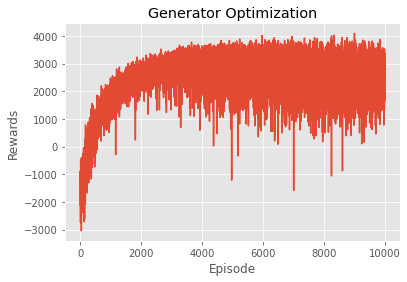

In [15]:
plt.plot(scores)
plt.title("Generator Optimization")
plt.xlabel("Episode")
plt.ylabel("Rewards")

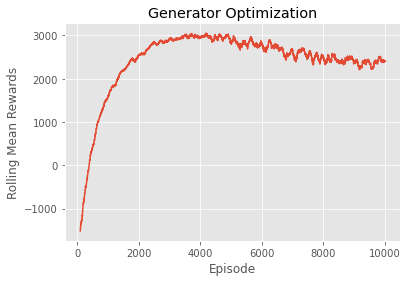

In [16]:
def plot_scores(scores, rolling_window=100):
    """Plot scores and optional rolling mean using specified window."""

    rolling_mean = pd.Series(scores).rolling(rolling_window).mean()
    plt.plot(rolling_mean)
    plt.title("Generator Optimization")
    plt.xlabel("Episode")
    plt.ylabel("Rolling Mean Rewards")
    return rolling_mean

rolling_mean = plot_scores(scores)

### 7. Watch a Q-Learning Agent

Define mission time (days)

In [17]:
days = 365*3
days

1095

Define plotting functions

In [18]:
def plot_current(df, xmax):
    ax = plt.gca()

    df.plot(kind='line', y='Target Current Load', ax=ax, xlim=(0, xmax), figsize=(10, 5))
    df.plot(kind='line', y='Available Current Capacity', ax=ax, xlim = (0, xmax), figsize=(10, 5))

    plt.xlabel('Days Since Mission Start')
    plt.ylabel('Current (A)')
    
def plot_gen_run(df, xmax):
    ax2 = plt.gca()
    ax2.ylabel = "Runtime"

    df.plot(kind='line', y='Generator 1 Runtime', ax=ax2, xlim=(0, xmax), figsize=(10, 5))
    df.plot(kind='line', y='Generator 2 Runtime', ax=ax2, xlim=(0, xmax), figsize=(10, 5))
    df.plot(kind='line', y='Generator 3 Runtime', ax=ax2, xlim=(0, xmax), figsize=(10, 5))

    plt.xlabel('Days Since Mission Start')
    plt.ylabel('Generator Runtime (Days)')

In [19]:
cols = ['Target Current Load', 
        'Available Current Capacity', 
        'Generator 1 Runtime', 
        'Generator 2 Runtime', 
        'Generator 3 Runtime',
        'Running Generator Count',
        'Failed Generator Count']

df = pd.DataFrame(columns=cols)

state = env.reset()
score = 0
action_list = []

for t in range(days): # was 365*3
    action = q_agent.act(state, mode='test')
    action_list.append(action)
    state, reward, done, _ = env.step(action)
    score += reward
    #print(state)
    df = df.append(pd.Series(state, index=cols), ignore_index=True)
    if done:
        break 

print('Final Reward:', score)
env.close()

Final Reward: 1896.0


In [20]:
df.shape

(669, 7)

In [21]:
df.head()

,Target Current Load,Available Current Capacity,Generator 1 Runtime,Generator 2 Runtime,Generator 3 Runtime,Running Generator Count,Failed Generator Count
0,0,483,1,0,0,1,0
1,0,483,2,0,0,1,0
2,39.2561,483,3,0,0,1,0
3,77.0543,483,4,0,0,1,0
4,113.439,483,5,0,0,1,0


In [22]:
df.describe()

,Target Current Load,Available Current Capacity,Generator 1 Runtime,Generator 2 Runtime,Generator 3 Runtime,Running Generator Count,Failed Generator Count
count,669.0,669.0,669.0,669.0,669.0,669.0,669.0
unique,668.0,4.0,356.0,359.0,341.0,4.0,3.0
top,0.0,966.0,356.0,358.0,34.0,2.0,0.0
freq,2.0,373.0,308.0,269.0,283.0,373.0,401.0


In [23]:
#for i in range(1, 50):
#    df = df.append(pd.Series(state, index=cols), ignore_index=True)

In [24]:
df.shape

(669, 7)

In [25]:
df.tail()

,Target Current Load,Available Current Capacity,Generator 1 Runtime,Generator 2 Runtime,Generator 3 Runtime,Running Generator Count,Failed Generator Count
664,439.675,483,356,358,337,1,1
665,443.532,483,356,358,338,1,1
666,447.179,483,356,358,339,1,1
667,450.622,483,356,358,340,1,1
668,453.868,0,356,358,340,0,2


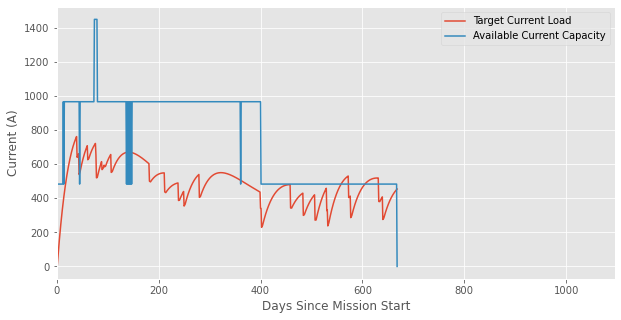

In [26]:
plot_current(df, days)

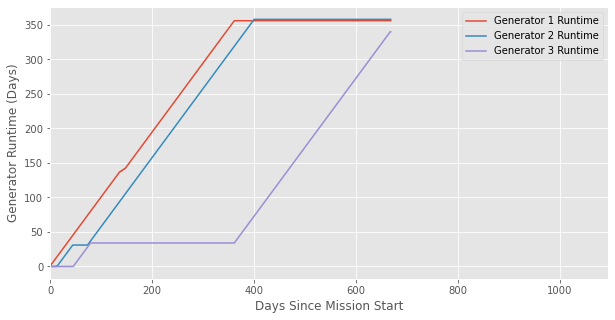

In [27]:
plot_gen_run(df, days)

In [28]:
len(action_list)

669

In [29]:
print(action_list)

[0, 5, 5, 5, 5, 9, 9, 9, 9, 9, 9, 9, 9, 3, 5, 3, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 9, 9, 9, 9, 4, 6, 4, 4, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 0, 8, 8, 8, 8, 8, 8, 3, 3, 3, 3, 8, 8, 8, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

# Random Generators On

In [30]:
state = env.reset()
score = 0

df_random = pd.DataFrame(columns=cols)

for t in range(days): # was 375*3 - error?
    action = env.action_space.sample()
    env.render()
    state, reward, done, _ = env.step(action)
    #print(state)
    df_random = df_random.append(pd.Series(state, index=cols), ignore_index=True)
    score += reward
    if done:
        break 

print('Final score:', score)
env.close()

Final score: -2481.0


In [31]:
df_random.shape

(1080, 7)

In [32]:
df_random.head()

,Target Current Load,Available Current Capacity,Generator 1 Runtime,Generator 2 Runtime,Generator 3 Runtime,Running Generator Count,Failed Generator Count
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,39.2561,483,1,0,0,1,0
3,77.0543,0,1,0,0,0,0
4,113.439,0,1,0,0,0,0


In [33]:
df_random.describe()

,Target Current Load,Available Current Capacity,Generator 1 Runtime,Generator 2 Runtime,Generator 3 Runtime,Running Generator Count,Failed Generator Count
count,1080.0,1080.0,1080.0,1080.0,1080.0,1080.0,1080
unique,1079.0,4.0,344.0,378.0,431.0,4.0,1
top,0.0,483.0,130.0,35.0,9.0,1.0,0
freq,2.0,460.0,48.0,40.0,40.0,460.0,1080


In [34]:
#for i in range(1, 50):
#    df_random = df_random.append(pd.Series(state, index=cols), ignore_index=True)

In [35]:
df_random.shape

(1080, 7)

In [36]:
df_random.tail()

,Target Current Load,Available Current Capacity,Generator 1 Runtime,Generator 2 Runtime,Generator 3 Runtime,Running Generator Count,Failed Generator Count
1075,403.663,483,340,377,430,1,0
1076,402.856,483,341,377,430,1,0
1077,402.034,483,342,377,430,1,0
1078,401.2,483,343,377,430,1,0
1079,400.354,0,343,377,430,0,0


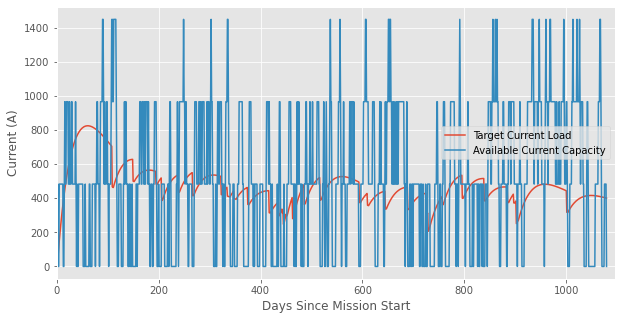

In [37]:
plot_current(df_random, days)

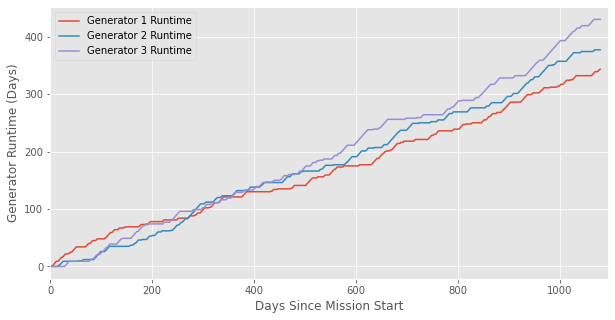

In [38]:
plot_gen_run(df_random, days)

# All Generators On

In [39]:
df_baseline = pd.DataFrame(columns=cols)

state = env.reset()
score = 0
choices = [0, 3, 6]

for t in range(days): # was 365*3
    action = random.choice(choices)
    env.render()
    state, reward, done, _ = env.step(action)
    #print(state) 
    df_baseline = df_baseline.append(pd.Series(state, index=cols), ignore_index=True)
    score += reward
    if done:
        break

print('Final score:', score)
env.close()

Final score: 1015.0


In [40]:
df_baseline.shape

(326, 7)

In [41]:
df_baseline.head()

,Target Current Load,Available Current Capacity,Generator 1 Runtime,Generator 2 Runtime,Generator 3 Runtime,Running Generator Count,Failed Generator Count
0,0,483,1,0,0,1,0
1,0,483,2,0,0,1,0
2,39.2561,966,3,1,0,2,0
3,77.0543,1449,4,2,1,3,0
4,113.439,1449,5,3,2,3,0


In [42]:
df_baseline.describe()

,Target Current Load,Available Current Capacity,Generator 1 Runtime,Generator 2 Runtime,Generator 3 Runtime,Running Generator Count,Failed Generator Count
count,326.0,326.0,326.0,326.0,326.0,326.0,326.0
unique,325.0,4.0,325.0,282.0,283.0,4.0,4.0
top,0.0,1449.0,325.0,281.0,282.0,3.0,0.0
freq,2.0,280.0,2.0,44.0,42.0,280.0,283.0


In [43]:
#for i in range(1, 100):
#    df_baseline = df_baseline.append(pd.Series(state, index=cols), ignore_index=True)

In [44]:
df_baseline.shape

(326, 7)

In [45]:
df_baseline.tail()

,Target Current Load,Available Current Capacity,Generator 1 Runtime,Generator 2 Runtime,Generator 3 Runtime,Running Generator Count,Failed Generator Count
321,366.107,483,322,281,282,1,2
322,372.533,483,323,281,282,1,2
323,378.672,483,324,281,282,1,2
324,384.533,483,325,281,282,1,2
325,390.126,0,325,281,282,0,3


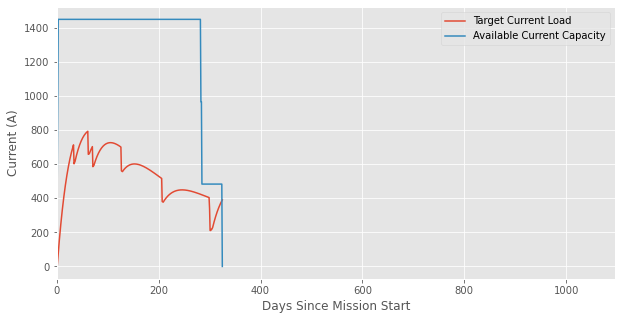

In [46]:
plot_current(df_baseline, days)

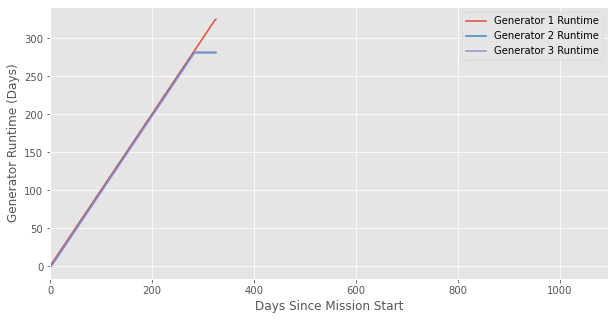

In [47]:
plot_gen_run(df_baseline, days)

# Thresholding Agent

In [48]:
df_thresh = pd.DataFrame(columns=cols)

state = env.reset()
score = 0

df_thresh = df_thresh.append(pd.Series(state, index=cols), ignore_index=True)

for t in range(days): # was 365*3
    
    # If Target Current Load is 90% of Max Current Capacity, 
    # turn on generator with least runtime
    if state[0] >= 0.90*state[1]:
        if state[2] <= state[3] and state[2] <= state[4]:
            action = 0
        elif state[3] <= state[2] and state[3] <= state[4]:
            action = 3
        elif state[4] <= state[2] and state[4] <= state[3]:
            action = 6
        else:
            action = 9
    
    # If no Generators are on, turn on a generator
    elif state[5] == 0:
        if state[2] <= state[3] and state[2] <= state[4]:
            action = 0
        elif state[3] <= state[2] and state[3] <= state[4]:
            action = 3
        elif state[4] <= state[2] and state[4] <= state[3]:
            action = 6
        else:
            action = random.choice([0, 3, 6])
    
    # If Target Current Load is less than 25% of Max Current Capacity, 
    # turn off generator with most runtime
    elif state[0] < 0.25*state[1] and state[5] > 1:
        if state[2] >= state[3] and state[2] >= state[4]:
            action = 1
        elif state[3] >= state[2] and state[3] >= state[4]:
            action = 4
        elif state[4] >= state[2] and state[4] >= state[3]:
            action = 7
        else:
            action = 9
        
    else:
        action = 9

    env.render()
    state, reward, done, _ = env.step(action)
    #print(state)   
    df_thresh = df_thresh.append(pd.Series(state, index=cols), ignore_index=True)
    score += reward
    if done:
        break

print('Final score:', score)
env.close()

Final score: 2037.0


In [49]:
df_thresh.shape

(641, 7)

In [50]:
df_thresh.head()

,Target Current Load,Available Current Capacity,Generator 1 Runtime,Generator 2 Runtime,Generator 3 Runtime,Running Generator Count,Failed Generator Count
0,0,0,0,0,0,0,0
1,0,483,1,0,0,1,0
2,0,483,2,0,0,1,0
3,39.2561,483,3,0,0,1,0
4,77.0543,483,4,0,0,1,0


In [51]:
df_thresh.describe()

,Target Current Load,Available Current Capacity,Generator 1 Runtime,Generator 2 Runtime,Generator 3 Runtime,Running Generator Count,Failed Generator Count
count,641.0,641.0,641.0,641.0,641.0,641.0,641.0
unique,639.0,3.0,297.0,295.0,369.0,3.0,3.0
top,0.0,483.0,253.0,294.0,0.0,1.0,0.0
freq,3.0,321.0,273.0,328.0,273.0,321.0,314.0


In [52]:
#for i in range(1, 500):
#    df_thresh = df_thresh.append(pd.Series(state, index=cols), ignore_index=True)

In [53]:
df_thresh.shape

(641, 7)

In [54]:
df_thresh.tail()

,Target Current Load,Available Current Capacity,Generator 1 Runtime,Generator 2 Runtime,Generator 3 Runtime,Running Generator Count,Failed Generator Count
636,488.045,483,296,294,364,1,2
637,492.539,483,296,294,365,1,2
638,496.78,483,296,294,366,1,2
639,500.777,483,296,294,367,1,2
640,504.538,0,296,294,368,0,2


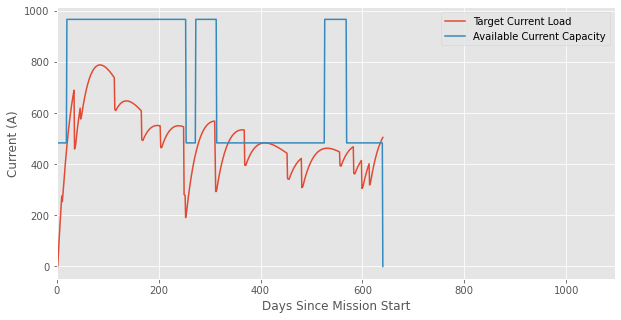

In [55]:
plot_current(df_thresh, days)

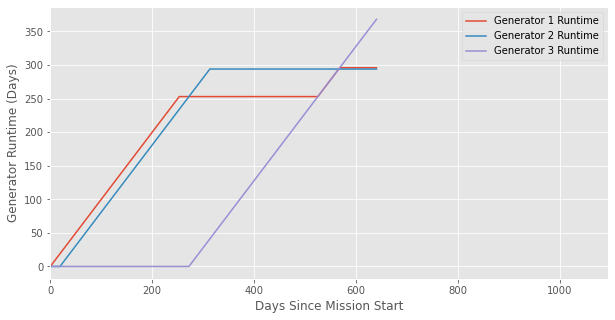

In [56]:
plot_gen_run(df_thresh, days)

# Thresholding Agent with Maintenance

In [57]:
df_thresh = pd.DataFrame(columns=cols)

state = env.reset()
score = 0

df_thresh = df_thresh.append(pd.Series(state, index=cols), ignore_index=True)

for t in range(days): # was 365*3
    
    # If Target Current Load is 90% of Max Current Capacity, 
    # turn on generator with least runtime
    if state[0] >= 0.90*state[1]:
        if state[2] <= state[3] and state[2] <= state[4]:
            action = 0
        elif state[3] <= state[2] and state[3] <= state[4]:
            action = 3
        elif state[4] <= state[2] and state[4] <= state[3]:
            action = 6
        else:
            action = 9
    
    # If no Generators are on, turn on a generator
    elif state[5] == 0:
        if state[2] <= state[3] and state[2] <= state[4]:
            action = 0
        elif state[3] <= state[2] and state[3] <= state[4]:
            action = 3
        elif state[4] <= state[2] and state[4] <= state[3]:
            action = 6
        else:
            action = random.choice([0, 3, 6])
    
    # If Target Current Load is less than 25% of Max Current Capacity, 
    # turn off generator with most runtime
    elif state[0] < 0.25*state[1] and state[5] > 1:
        if state[2] >= state[3] and state[2] >= state[4]:
            action = 2
        elif state[3] >= state[2] and state[3] >= state[4]:
            action = 5
        elif state[4] >= state[2] and state[4] >= state[3]:
            action = 8
        else:
            action = 9
        
    else:
        action = 9

    env.render()
    state, reward, done, _ = env.step(action)
    #print(state)   
    df_thresh = df_thresh.append(pd.Series(state, index=cols), ignore_index=True)
    score += reward
    if done:
        break

print('Final score:', score)
env.close()

Final score: 2511.0


In [58]:
df_thresh.shape

(759, 7)

In [59]:
df_thresh.head()

,Target Current Load,Available Current Capacity,Generator 1 Runtime,Generator 2 Runtime,Generator 3 Runtime,Running Generator Count,Failed Generator Count
0,0,0,0,0,0,0,0
1,0,483,1,0,0,1,0
2,0,483,2,0,0,1,0
3,39.2561,483,3,0,0,1,0
4,77.0543,483,4,0,0,1,0


In [60]:
df_thresh.describe()

,Target Current Load,Available Current Capacity,Generator 1 Runtime,Generator 2 Runtime,Generator 3 Runtime,Running Generator Count,Failed Generator Count
count,759.0,759.0,759.0,759.0,759.0,759.0,759.0
unique,757.0,3.0,556.0,369.0,322.0,3.0,2.0
top,0.0,966.0,187.0,368.0,321.0,2.0,0.0
freq,3.0,485.0,204.0,374.0,235.0,485.0,525.0


In [61]:
#for i in range(1, 500):
#    df_thresh = df_thresh.append(pd.Series(state, index=cols), ignore_index=True)

In [62]:
df_thresh.shape

(759, 7)

In [63]:
df_thresh.tail()

,Target Current Load,Available Current Capacity,Generator 1 Runtime,Generator 2 Runtime,Generator 3 Runtime,Running Generator Count,Failed Generator Count
754,437.373,483,551,368,321,1,1
755,443.154,483,552,368,321,1,1
756,448.65,483,553,368,321,1,1
757,453.868,483,554,368,321,1,1
758,458.819,0,555,368,321,0,1


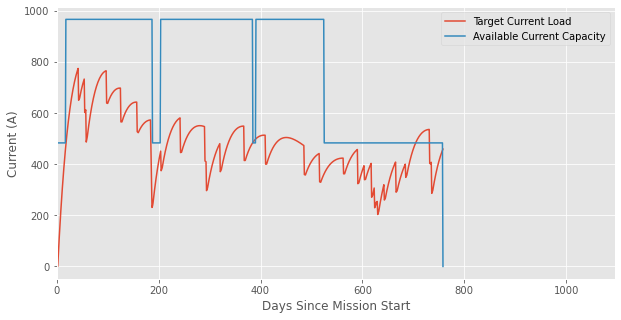

In [64]:
plot_current(df_thresh, days)

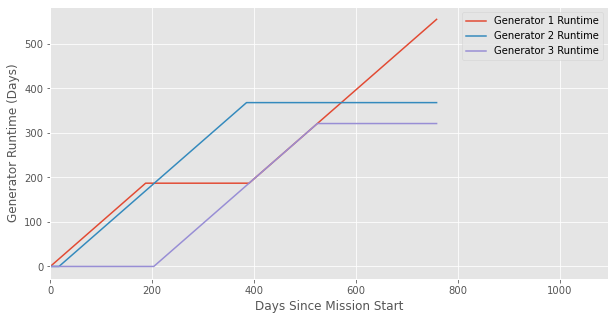

In [65]:
plot_gen_run(df_thresh, days)